# FAIRshake Mouse Genome Informatics Tools Evaluation Summary

In [9]:
import sys
import re
print("Created by Brian Schilder, 07/22/2018\n")
print("Modified by Megan Wojciechowicz, 07/23/2018\n")
print("Python Version Info:")
print(sys.version)


Created by Brian Schilder, 07/22/2018

Modified by Megan Wojciechowicz, 07/23/2018

Python Version Info:
3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


## Summary Questions
- Average score for each question
- Standard deviation for each answer
- Correlation between questions
- Evals per person, max evals, and distribution
- Are some people generally harsher
- Which answers tended to have comments
- FAIRest tools vs. Least FAIR tools

## FAIRshake Questions
1. DESCRIPTION : The tool has a unique name and an informative description.
2. DOWNLOAD : The tool can be freely downloaded or accessed from a webpage.
3. ONTOLOGY : The tool utilizes a community-accepted ontology.
4. TUTORIAL : Tutorials for the tool are available on the tool's homepage.
5. SOURCE CODE : Source code is shared in a public repository and is documented.
6. VERSIONING : Previous versions of the tool are made available.
7. CONTACT: Contact information is provided for the creator(s) of the tool and information describing how to cite the tool is provided.
8. API : The tool can be accessed programmatically through an API and follows community standards for open APIs.
9. LICENSE : Licensing information is provided on the tool's homepage.


In [18]:
import matplotlib
import warnings
import numpy as np
warnings.filterwarnings('ignore')

import pandas as pd
fair = pd.read_json("fairshake_db_no_limit.json")

# Only select rows that had a q_id from 1-9
# Only select Rat Genome Database Results 
fair = fair[fair['q_id'] < 10]
fair = fair[fair.resource_name.str.contains('Mouse Genome Informatics:')]
fair['q_id'] = pd.Categorical(fair['q_id'])
print(fair.shape)
print(fair.columns)
qDict = {1:'1. Description', 2:'2. Download', 3:'3. Ontology', 4:'4. Tutorial', 
         5:'5. Source Code', 6:'6. Versioning', 7:'7. Contact', 8:'8. API', 9:'9. License'}
fair["q_name"] = fair['q_id'].map(qDict)
print("+++++++++++++++++")
print(str(int(len(fair)/9)) + " evaluations total.")
print(str(len(np.unique(fair["resource_name"])))+" resources total.")

(225, 29)
Index(['A', 'F', 'I', 'R', 'answer', 'comment', 'content', 'description',
       'first_name', 'kind', 'last_name', 'num', 'project_description',
       'project_id', 'project_img', 'project_name', 'q_id', 'res_type',
       'resource_id', 'resource_name', 'resource_type', 'role_evaluator',
       'role_starter', 'test', 'url', 'url_comment', 'user_id', 'username',
       'version'],
      dtype='object')
+++++++++++++++++
25 evaluations total.
24 resources total.


## Average score for each question

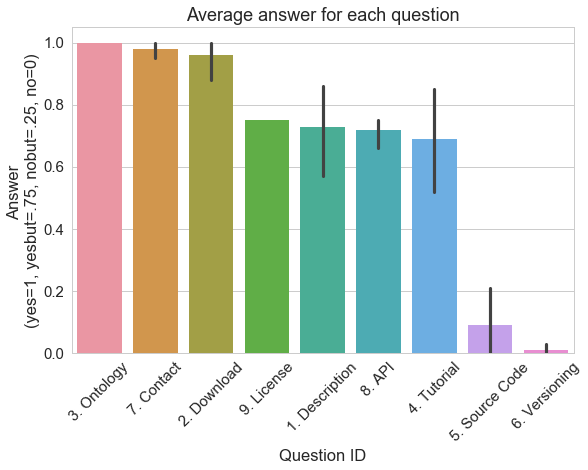

In [20]:
import seaborn as sn
sn.set(font_scale=1.5)
import matplotlib.pyplot as plt
sn.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(9, 6)) #default figsize = (8,6) 

fair.answer.unique()
fair["answer01"] = fair.answer.map(dict(yes=1, no=0, yesbut=.75, nobut=.25))
avg_per_q = fair.groupby('q_name')['q_name','answer01'].mean()
std_per_q = fair.groupby('q_name')['q_name','answer01'].std()
avg_per_q.rename(columns={'answer01':'answer01_mean'}, inplace=True)
avg_per_q = avg_per_q.sort_values(by='answer01_mean', ascending=False)

# plot
# fair = fair.merge(avg_per_q, on='q_id')
g = sn.barplot(data=fair, x='q_name', y='answer01', order=avg_per_q.index)
# ax = sn.violinplot(data=fair, x='q_id', y='answer01', order=avg_per_q.index)
g.set(ylabel='Answer \n(yes=1, yesbut=.75, nobut=.25, no=0)', xlabel='Question ID', title="Average answer for each question")
plt.xticks(rotation=45, ha='center')
#plt.savefig("MGI_tools_avg_answer.png",dpi=300,bbox_inches='tight')
plt.show()

## Frequency of each of the 4 score options for each question

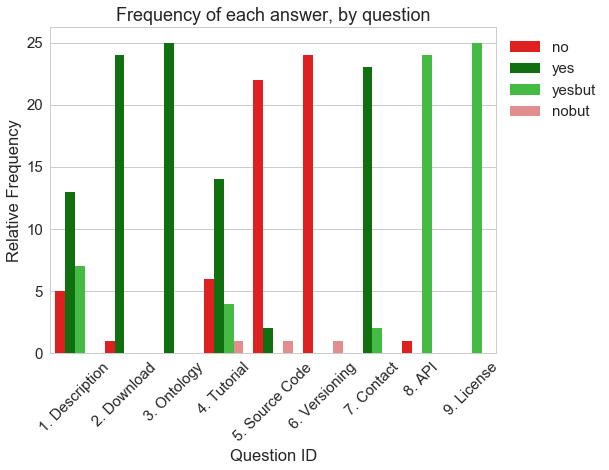

In [21]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

scores4 = fair.groupby(['q_name','answer'])['answer'].count()
scores4.name = 'answerCount'
scores4 = scores4.reset_index()
palette ={"no":"red","nobut":"lightcoral", "yes":"green", "yesbut":"limegreen"}
g = sn.barplot(data=scores4, x='q_name', y='answerCount', hue='answer', palette=palette)
g.set(ylabel='Relative Frequency', xlabel='Question ID', title="Frequency of each answer, by question")
g.legend()
ax.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=45, ha='center')
#plt.savefig("MGI_tools_answer_breakdown.png",dpi=300,bbox_inches='tight')
plt.show()

## Correlations between questions

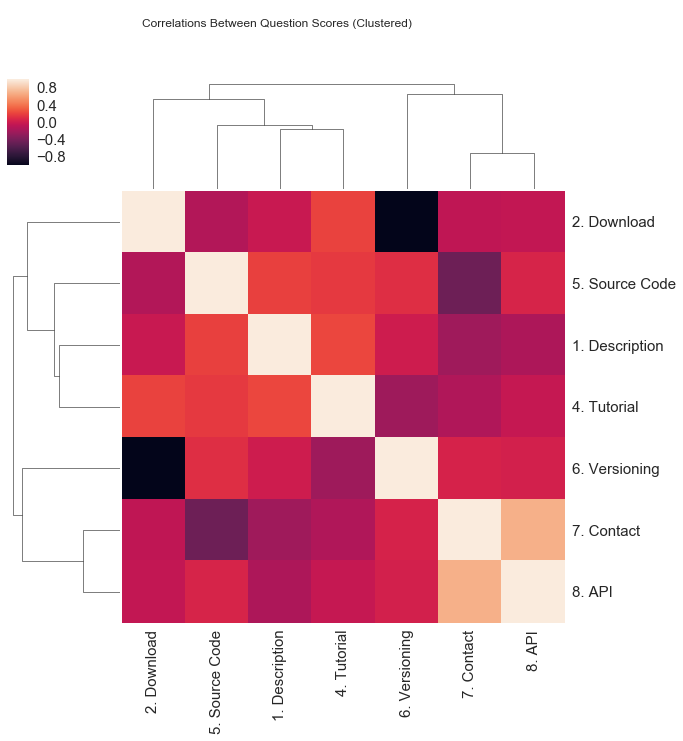

There is some positive correlation between q7 (Contact) and q8 (API).
There is some negative correlation between q2 (Download) and q6 (Versioning).


In [23]:
import seaborn as sns
#fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

corrDict={}
for q in fair['q_name']:
    sub = fair.loc[fair['q_name']==q]['answer01']
    corrDict[q] = sub.values
corrMatrix = pd.DataFrame(corrDict).corr()

# remove columns with NA's 
corrMatrix=corrMatrix.drop(['3. Ontology','9. License'],axis=1)
corrMatrix=corrMatrix.drop(['3. Ontology','9. License'], axis=0)

sns.clustermap(data=corrMatrix).fig.suptitle('\nCorrelations Between Question Scores (Clustered)', size=12)
#plt.savefig("MGI_tools_correlation.png",dpi=300,bbox_inches='tight')
plt.show()

print("There is some positive correlation between q7 (Contact) and q8 (API).")
print("There is some negative correlation between q2 (Download) and q6 (Versioning).")

## KDE Density Plots of Evaluations Per Person

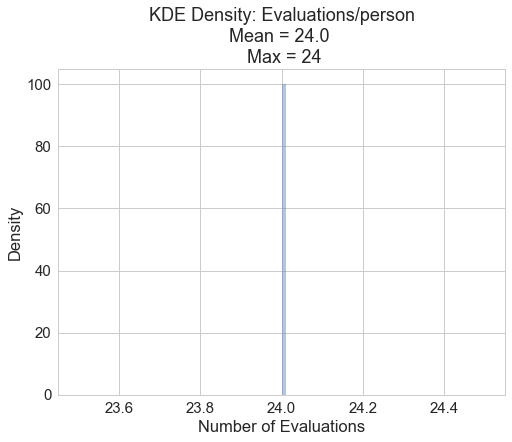

In [24]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

evalCounts = [len(x) for x in fair.groupby('user_id')['resource_name'].unique()]
avgCounts = sum(evalCounts)/len(evalCounts)


g = sn.distplot(evalCounts, bins=100)
g.set(xlabel='Number of Evaluations', ylabel='Density', 
       title="KDE Density: Evaluations/person\n Mean = "+str(round(avgCounts,2))+"  \n Max = "+str(max(evalCounts)))
plt.show()

## Are some raters harsher than others?

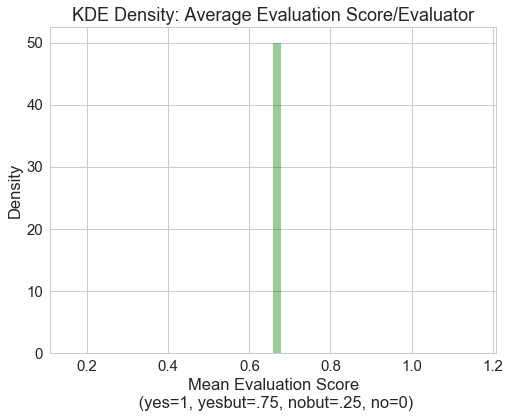

Evaluators gave a average FAIR score of 0.66 (on a 0-1 scale).


In [25]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

avgRating = fair.groupby('user_id')['user_id','answer01'].mean()
meanMean = avgRating['answer01'].mean()
g = sn.distplot(avgRating['answer01'], bins=50, color='green')
g.set(xlabel='Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)', ylabel='Density', 
       title="KDE Density: Average Evaluation Score/Evaluator")
plt.show()
print("Evaluators gave a average FAIR score of "+str(round(meanMean,2)) + " (on a 0-1 scale).")


## Which answers tended to have the most comments

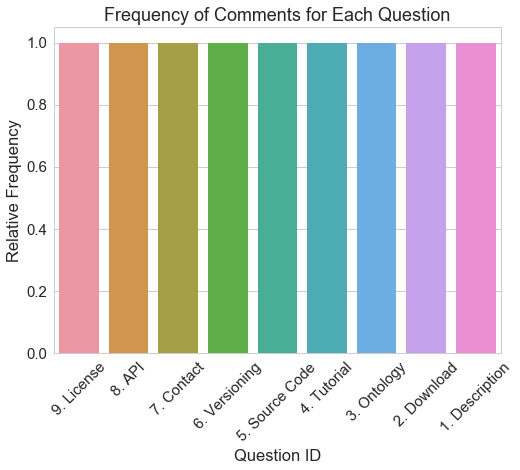

Questions 9. License and 8. API most frequently had comments.


In [26]:
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

commentDict={}
for q in fair['q_name'].unique():
    sub = fair.loc[fair['q_name']==q]['comment']
    notEmpty = sum(~sub.isnull())/len(sub.isnull())
    commentDict[q] = notEmpty
commentDF = pd.Series(commentDict).sort_values(ascending=False)

g = sn.barplot(x=commentDF.index, y=commentDF )
g.set(xlabel='Question ID', ylabel='Relative Frequency', 
       title="Frequency of Comments for Each Question")
plt.xticks(rotation=45, ha='center')
plt.show()
print("Questions "+commentDF.index[0]+" and "+commentDF.index[1]+ " most frequently had comments.")

## The FAIRest of the them all

In [27]:
resourceScores = fair.groupby('resource_name')['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==max(resourceScores['answer01']),:]

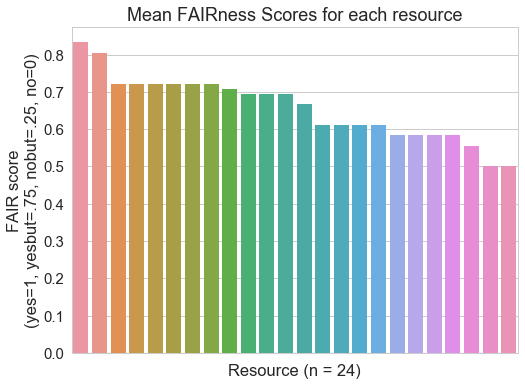

FAIRest resources (score = 0.833333333333)
                                       resource_name  answer01
0  Mouse Genome Informatics: MGI Gene Ontology Te...  0.833333


Least FAIR resources ( score = 0.5)
                                        resource_name  answer01
1   Mouse Genome Informatics: MGI Gene Ontology GO...  0.805556
2   Mouse Genome Informatics: Recombinase (cre) Ac...  0.722222
3   Mouse Genome Informatics: Phenotypes, Alleles ...  0.722222
4   Mouse Genome Informatics: Genealogy Chart of I...  0.722222
5     Mouse Genome Informatics: Genes & Markers Query  0.722222
6   Mouse Genome Informatics: Human – Mouse: Disea...  0.722222
7   Mouse Genome Informatics: Inbred Strain Charac...  0.722222
8   Mouse Genome Informatics: Gene Expression Lite...  0.708333
9   Mouse Genome Informatics: Adult Mouse Anatomy ...  0.694444
10     Mouse Genome Informatics: Mouse Genome Browser  0.694444
11  Mouse Genome Informatics: Mouse Tumor Biology ...  0.694444
12               Mouse Ge

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6)) #default figsize = (8,6)

resourceScores = fair.groupby(['resource_name'])['answer01'].mean().sort_values(ascending=False).reset_index()
FAIRest = resourceScores.loc[resourceScores['answer01']==max(resourceScores['answer01']),:]
leastFAIR  = resourceScores.loc[resourceScores['answer01']< max(resourceScores['answer01']),:]

g = sn.barplot(data=resourceScores, x='resource_name', y='answer01')
g.set(xlabel='Resource (n = '+str(len(resourceScores))+')', ylabel='FAIR score\n(yes=1, yesbut=.75, nobut=.25, no=0)', 
       title="Mean FAIRness Scores for each resource")
g.set(xticklabels=[])
#plt.savefig("MGI_tools_mean_fairness.png",dpi=300,bbox_inches='tight')
plt.show()
print("FAIRest resources (score = "+ str(max(resourceScores['answer01'])) +")")
print(FAIRest)
print("\n")
print("Least FAIR resources ( score = "+ str(min(resourceScores['answer01'])) +")")
print(leastFAIR)

## Histogram of FAIR scores across resources 

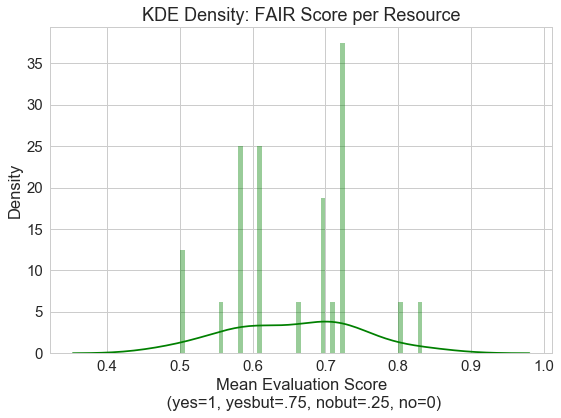

In [31]:
fig,ax = plt.subplots(figsize =(9,6))

g=sn.distplot(resourceScores['answer01'],bins=50,color='green',norm_hist=False)
g.set(xlabel="Mean Evaluation Score\n (yes=1, yesbut=.75, nobut=.25, no=0)", ylabel='Density', title='KDE Density: FAIR Score per Resource')
#plt.savefig("MGI_tools_overall_fairness.png",dpi=300,bbox_inches='tight')
plt.show()